# Analysis code

Code for stats + figures.

Run this notebook from the `scripts` folder. Before running, ensure all default
values have been populated with `./scripts/update_param_list_in_model_yaml.sh`.

## Preamble (always run)

In [1]:
# for plotting
%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
# imports
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import pingouin as pg
# import statsmodels as sm
# import statsmodels.formula.api as smf
from matplotlib import pyplot as plt

sns.set_theme('paper', font_scale=2)

%aimport exp_utils
from exp_utils import *

WIDTHS = (2, 4, 8, 16, 32, 64, 128)
STEPS = (1, 3, 6, 12, 24)

## ZeroSpeech libriABX analysis

In [3]:
# load zrc data
dfz = collate_data()
dfz.head(10)

,zrc.subset,zrc.speaker_mode,zrc.context_mode,zrc.granularity,zrc.score,zrc.pooling,zrc.seed,zrc.pca_style,name,feat_type,...,training.best_rq_loss.mask_prob,training.best_rq_loss.mask_width,training.best_rq_loss.codebook_size,training.best_rq_loss.codebook_dim,training.best_rq_loss.offset,training.best_rq_loss.speaker_regex,training.best_rq_loss.prediction_type,training.shuffle,training.max_epochs,training.early_stopping_patience
0,dev-clean,within,within,triphone,0.1784,none,3459,full,bestrq.csa128/version_0101,fbank-80,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10
1,dev-clean,across,within,triphone,0.3216,none,3459,full,bestrq.csa128/version_0101,fbank-80,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10
2,dev-other,within,within,triphone,0.2102,none,3459,full,bestrq.csa128/version_0101,fbank-80,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10
3,dev-other,across,within,triphone,0.3732,none,3459,full,bestrq.csa128/version_0101,fbank-80,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10
4,test-clean,within,within,triphone,0.1809,none,3459,full,bestrq.csa128/version_0101,fbank-80,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10
5,test-clean,across,within,triphone,0.3077,none,3459,full,bestrq.csa128/version_0101,fbank-80,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10
6,test-other,within,within,triphone,0.2259,none,3459,full,bestrq.csa128/version_0101,fbank-80,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10
7,test-other,across,within,triphone,0.3804,none,3459,full,bestrq.csa128/version_0101,fbank-80,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10
8,dev-clean,within,within,phoneme,0.1268,none,3459,full,bestrq.csa128/version_0101,fbank-80,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10
9,dev-clean,across,within,phoneme,0.2534,none,3459,full,bestrq.csa128/version_0101,fbank-80,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10


In [4]:
# determine significance of context windows

df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.cpc_loss.prediction_steps": 12,
    "training.cpc_loss.gutted_steps": 0,
    "training.cpc_loss.negative_samples": 128,
    "training.loss_type": "cpc",
    "zrc.granularity": "phoneme",
    'training.cpc_loss.averaging_penalty': 0,
    "training.max_epochs": 200,
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "zrc.speaker_mode": "within",
    "train_part": '100',
})
df = filter_data_in(
    df, {"csa.max_width": WIDTHS}
)
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score", "zrc.context_mode"
)

# 5 seeds * 7 context widths * 2 context modes * 4 partitions
assert len(df) == 5 * 7 * 2 * 4

df = df[['name', 'csa.max_width', 'zrc.score']].groupby('name', as_index=False, observed=True, sort=True).mean(numeric_only=True)
df['csa.max_width'] = df['csa.max_width'].astype('int').astype('category')

pg.print_table(pg.anova(data=df, dv='zrc.score', between='csa.max_width'))
pg.print_table(pg.normality(data=df, dv='zrc.score', group='csa.max_width'))
pg.print_table(pg.homoscedasticity(data=df, dv='zrc.score', group='csa.max_width'))

pg.print_table(pg.pairwise_tests(data=df, dv='zrc.score', between='csa.max_width', parametric=False, return_desc=True))



ANOVA SUMMARY

Source           ddof1    ddof2      F    p-unc    np2
-------------  -------  -------  -----  -------  -----
csa.max_width        6       28  5.876    0.000  0.557

    W    pval  normal
-----  ------  --------
0.861   0.232  True
0.922   0.542  True
0.854   0.207  True
0.893   0.372  True
0.950   0.734  True
0.924   0.555  True
0.967   0.853  True

    W    pval  equal_var
-----  ------  -----------
0.855   0.539  True


POST HOC TESTS

Contrast         A    B    mean(A)    std(A)    mean(B)    std(B)  Paired    Parametric      U-val  alternative      p-unc    hedges
-------------  ---  ---  ---------  --------  ---------  --------  --------  ------------  -------  -------------  -------  --------
csa.max_width    2    4      0.136     0.003      0.122     0.014  False     False          20.000  two-sided        0.151     1.224
csa.max_width    2    8      0.136     0.003      0.135     0.013  False     False          12.000  two-sided        1.000     0.099
csa.max_w

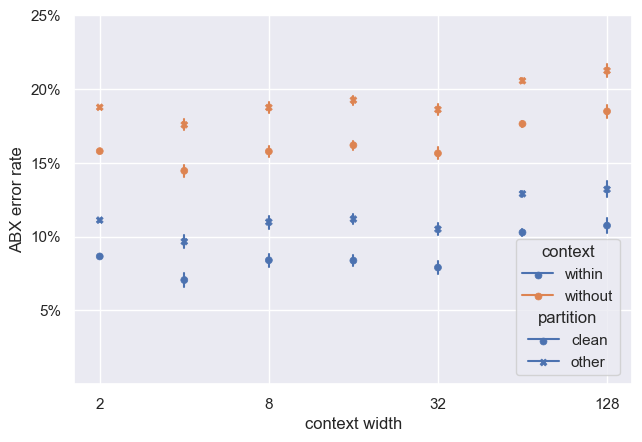

In [5]:
# plot libriABX scores across subsets and context windows w/ phoneme granularity

fig = plt.figure(1, figsize=[6.8, 4.8])
# # cpc.small results
# df = filter_data_equal(dfz, {
#     'name': 'cpc.small/version_2',
#     "zrc.pca_style": "full",
#     "zrc.speaker_mode": "within",
#     "zrc.granularity": "phoneme",
# }).copy()
# df['zrc.subset'] = df['zrc.subset'].map(
#     {
#         'test-clean': 'clean',
#         'test-other': 'other',
#         'dev-clean': 'clean',
#         'dev-other': 'other'}
# )
# df['zrc.context_mode'] = df['zrc.context_mode'].map({'within': 'within', 'any': 'without'})
# df = (
#     df[['zrc.context_mode', 'zrc.subset', 'zrc.score']]
#     .groupby(['zrc.context_mode', 'zrc.subset']).mean()
# )
# ax.axhline(y=df.loc[('within', 'clean'), 'zrc.score'], color=sns.color_palette()[0], linestyle='--', alpha=0.75)
# ax.axhline(y=df.loc[('without', 'clean'), 'zrc.score'], color=sns.color_palette()[1], linestyle='--', alpha=0.75)

df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.cpc_loss.prediction_steps": 12,
    "training.cpc_loss.gutted_steps": 0,
    "training.cpc_loss.negative_samples": 128,
    "training.loss_type": "cpc",
    "zrc.granularity": "phoneme",
    'training.cpc_loss.averaging_penalty': 0,
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "training.max_epochs": 200,
    "zrc.speaker_mode": "within",
    "train_part": "100",
})
df = filter_data_in(
    df, {"csa.max_width": WIDTHS}
)
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score",
    "zrc.context_mode"
)

# 5 seeds * 7 context widths * 2 context modes * 4 partitions
assert len(df) == 5 * 7 * 2 * 4

# aggregate dev and test into their quality
df['zrc.subset'] = df['zrc.subset'].map(
    {
        'test-clean': 'clean',
        'test-other': 'other',
        'dev-clean': 'clean',
        'dev-other': 'other'}
)
df['zrc.context_mode'] = df['zrc.context_mode'].map({'within': 'within', 'any': 'without'})

# ensure each point in a vertical slice gets its own error bar
df['zrc.sbyc'] = df.agg("{0[zrc.subset]}-{0[zrc.context_mode]}".format, axis=1)

plot = (
    so.Plot(df, x="csa.max_width", y="zrc.score", color="zrc.context_mode", marker="zrc.subset")
    .limit(y=(0.00, 0.25))
    .add(so.Dot(pointsize=5), so.Agg())
    .add(so.Range(), so.Est(errorbar="se"), group='zrc.sbyc')  # 1 standard error
    # .add(so.Line(marker=None), so.PolyFit())  # misleading?
    .scale(
        x=(
            so.Continuous(trans="log")
            .tick(at=[2, 8, 32, 128])
            .label(like='d', base=2)
        ),
        y=(
            so.Continuous()
            .tick(at=[0.05, 0.1, 0.15, 0.2, 0.25])
            .label(like='.0%')
        ),
    )
    .label(x="context width", y="ABX error rate", color="context", marker="partition")
    .on(fig)
)

plot.plot()

leg = fig.legends[0]
bb = leg.get_bbox_to_anchor().transformed(fig.axes[0].transAxes.inverted())
bb.x0 -= .325
bb.y0 -= .725
leg.set_bbox_to_anchor(bb, transform=fig.axes[0].transAxes)

fig.tight_layout()
fig.savefig('../resources/libriabx_context_subset_phoneme.pdf')

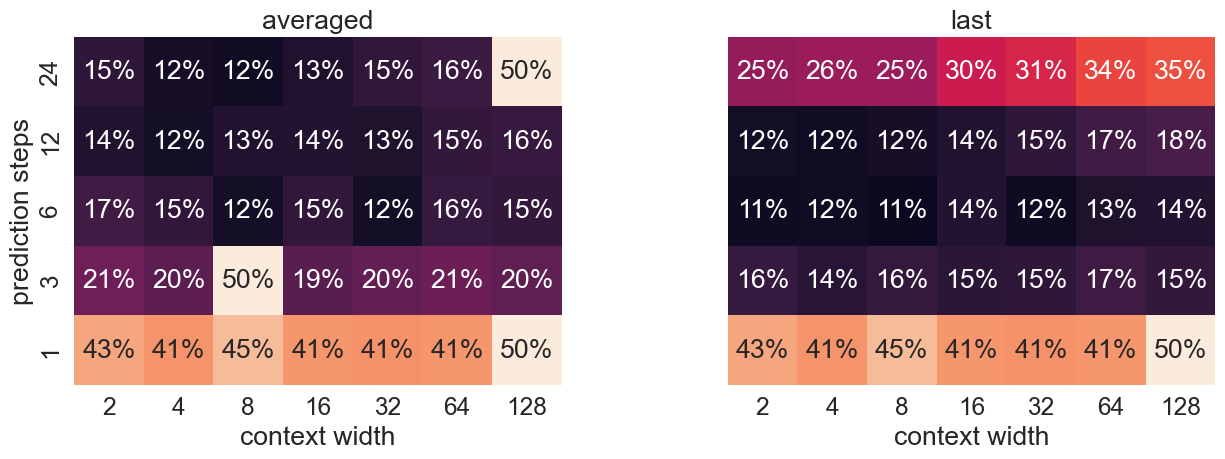

In [6]:
# plot libriABX score of context width vs prediction steps (averaged)
# - this one will show up on the left of our figure, so it doesn't have the cbar
#   but does have the y axis label
fig, axs = plt.subplots(1, 2, figsize=(14, 4.8), sharey=True)

df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    "training.cpc_loss.gutted_steps": 0,
    'training.cpc_loss.averaging_penalty': 0,
    "zrc.granularity": "phoneme",
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "zrc.speaker_mode": "within",
    "training.max_epochs": 200,
    "train_part": "100",
})
df = filter_data_in(
    df, {
        "csa.max_width": WIDTHS,
        "training.cpc_loss.prediction_steps": STEPS,
    }
)
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score",
    "zrc.context_mode",
    "training.cpc_loss.prediction_steps"
)
df = df.pivot_table(
    columns="csa.max_width",
    index="training.cpc_loss.prediction_steps",
    values="zrc.score"
).sort_values(by='training.cpc_loss.prediction_steps', ascending=False)
plot = sns.heatmap(df, annot=True, fmt=".0%", vmin=0.1, vmax=0.5, cbar=False, square=True, ax=axs[0])
plot.set(xlabel='context width', ylabel='prediction steps', title='averaged')
plot.set_xticklabels([f'{int(x):d}' for x in sorted(df.columns)])

df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    'training.cpc_loss.averaging_penalty': 0,
    "training.cpc_loss.negative_samples": 128,
    "zrc.granularity": "phoneme",
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "zrc.speaker_mode": "within",
    "training.max_epochs": 200,
    "train_part": "100",
})
df = filter_data_in(
    df, {"csa.max_width": WIDTHS}
)
idx = df['training.cpc_loss.prediction_steps'] == 1
for n in range(2, 25):
    idx |= (df['training.cpc_loss.prediction_steps'] == n) & (df['training.cpc_loss.gutted_steps'] == (n - 1))
df = df.loc[idx]
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score",
    "zrc.context_mode",
    "training.cpc_loss.prediction_steps",
    "training.cpc_loss.gutted_steps",
)
df = df.pivot_table(
    columns="csa.max_width",
    index="training.cpc_loss.prediction_steps",
    values="zrc.score"
).sort_values(by='training.cpc_loss.prediction_steps', ascending=False)
plot = sns.heatmap(df, annot=True, fmt=".0%", vmin=0.1, vmax=0.5, square=True, cbar=False, ax=axs[1])
plot.set(xlabel='context width', ylabel=None, title='last')
plot.set_xticklabels([f'{int(x):d}' for x in sorted(df.columns)])
plot.set_yticklabels([f'{int(x):d}' for x in sorted(df.index, reverse=True)])

fig.tight_layout()
fig.savefig("../resources/libriabx_prediction_steps_vs_width.pdf")

In [7]:
# aggregate prediction steps over context widths and print as table

df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    'training.cpc_loss.averaging_penalty': 0,
    "zrc.granularity": "phoneme",
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "zrc.speaker_mode": "within",
    "training.max_epochs": 200,
    "train_part": "100",
})

df_1 = filter_data_in(
    df, {
        "csa.max_width": WIDTHS,
        "training.cpc_loss.prediction_steps": STEPS,
        "training.cpc_loss.gutted_steps": (0,),
    }
)
check_data(
    df_1,
    "csa.max_width", "zrc.subset", "zrc.score",
    "zrc.context_mode",
    "training.cpc_loss.prediction_steps"
)
df_1.loc[:, 'name'] = 'averaged'

df_2 = filter_data_in(
    df, {
        "csa.max_width": WIDTHS,
        "training.cpc_loss.prediction_steps": STEPS,
    }
)
idx = df_2['training.cpc_loss.prediction_steps'] == 1
for n in range(2, 25):
    idx |= (df_2['training.cpc_loss.prediction_steps'] == n) & (df_2['training.cpc_loss.gutted_steps'] == (n - 1))
df_2 = df_2.loc[idx]
check_data(
    df_2,
    "csa.max_width", "zrc.subset", "zrc.score",
    "zrc.context_mode",
    "training.cpc_loss.prediction_steps",
    "training.cpc_loss.gutted_steps",
)
df_2.loc[:, 'name'] = 'last'

df = pd.concat([df_1, df_2])
df['training.cpc_loss.prediction_steps'] = df['training.cpc_loss.prediction_steps'].astype('int')
df = pd.pivot_table(df, values='zrc.score', columns='training.cpc_loss.prediction_steps', index='name')

(df * 100).style.format(precision=1)

training.cpc_loss.prediction_steps,1,3,6,12,24
name,,,,,
averaged,43.3,24.5,14.7,13.9,19.1
last,43.3,15.3,12.4,14.2,29.6


In [13]:
# various means for stats table
# (main can be derived from the above figure)

row2names = {
    "main":  set(f'cpc.csa{w}/version_{v:04d}' for w in WIDTHS for v in range(101, 106)),
    "long train": set(f'cpc.csa{w}/version_0012' for w in WIDTHS),
    "960h": set(f'cpc.csa{w}/version_0003' for w in WIDTHS),
    "2-layer": set(f'cpc.csa{w}/version_1001' for w in WIDTHS),
    "4-layer": set(f'cpc.csa{w}/version_1101' for w in WIDTHS),
    "conv (fixed size)": set(f"cpc.cconv{w}/version_0101" for w in WIDTHS),
    "conv (fixed H_2)": set(f"cpc.cconv{w}/version_0201" for w in WIDTHS),
    "BEST-RQ": set(f"bestrq.csa{w}/version_0101" for w in WIDTHS),
}
name2row = dict()
for row, names in row2names.items():
    name2row.update((name, row) for name in names)

df = filter_data_equal(dfz, {"zrc.speaker_mode": "within", "zrc.granularity": "phoneme"})
df = filter_data_in(df, {'name': set(name2row)}).copy()

df['csa.max_width'] = df['csa.max_width'].astype('int') #.where(~df['csa.max_width'].isna(), df['cconv.kernel_size']).astype('int')

df['name'] = df['name'].cat.remove_unused_categories().apply(lambda x: name2row[x])

df = pd.pivot_table(df, values='zrc.score', columns='csa.max_width', index='name')

(df * 100).style.format(precision=1)

csa.max_width,2,4,8,16,32,64,128
name,,,,,,,
960h,nan,nan,15.0,nan,nan,nan,15.9
BEST-RQ,21.8,19.2,19.0,20.7,20.7,22.0,19.8
long train,11.1,10.8,12.2,12.9,12.7,13.1,13.0
main,13.6,12.2,13.5,13.7,13.2,15.3,15.9


In [9]:
# the mean abx error rates for the models we trained downstream ASR systems for
# (also the the mininum ABX of the repeat trials over context widths)

df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.cpc_loss.prediction_steps": 12,
    "training.cpc_loss.gutted_steps": 0,
    "training.cpc_loss.negative_samples": 128,
    "training.loss_type": "cpc",
    "zrc.granularity": "phoneme",
    'training.cpc_loss.averaging_penalty': 0,
    "training.max_epochs": 200,
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "zrc.speaker_mode": "within",
    "train_part": "100",
})
df = filter_data_in(
    df, {"csa.max_width": WIDTHS}
)
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score", "zrc.context_mode"
)

df = df[['name', 'csa.max_width', 'zrc.score']].groupby(['name']).mean().dropna()
# 5 seeds * 7 context widths
assert len(df) == 5 * 7

min_idxs = []
for w in WIDTHS:
    min_idxs.append(df[df['csa.max_width'] == w]['zrc.score'].idxmin())
min_df_100 = df.loc[min_idxs]
min_df_100['csa.max_width'] = min_df_100["csa.max_width"].astype('int')
print(min_df_100)

                         csa.max_width  zrc.score
name                                             
cpc.csa2/version_0105                2   0.132688
cpc.csa4/version_0102                4   0.103850
cpc.csa8/version_0101                8   0.115375
cpc.csa16/version_0103              16   0.121950
cpc.csa32/version_0104              32   0.118600
cpc.csa64/version_0101              64   0.145575
cpc.csa128/version_0101            128   0.140088


## Tensorboard analysis

In [10]:
# load data
dft = collate_data("tb")
dft.head(10)

,tb.step,tb.epoch,tb.val_loss,name,feat_type,train_part,input_size,latent_type,context_type,version,...,training.best_rq_loss.mask_prob,training.best_rq_loss.mask_width,training.best_rq_loss.codebook_size,training.best_rq_loss.codebook_dim,training.best_rq_loss.offset,training.best_rq_loss.speaker_regex,training.best_rq_loss.prediction_type,training.shuffle,training.max_epochs,training.early_stopping_patience
0,1902,0,0.514025,bestrq.csa128/version_0101,fbank-80,100,80,ff,csa,101,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10
1,3805,1,0.347518,bestrq.csa128/version_0101,fbank-80,100,80,ff,csa,101,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10
2,5708,2,0.275961,bestrq.csa128/version_0101,fbank-80,100,80,ff,csa,101,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10
3,7611,3,0.222729,bestrq.csa128/version_0101,fbank-80,100,80,ff,csa,101,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10
4,9514,4,0.198708,bestrq.csa128/version_0101,fbank-80,100,80,ff,csa,101,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10
5,11417,5,0.202900,bestrq.csa128/version_0101,fbank-80,100,80,ff,csa,101,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10
6,13320,6,0.180398,bestrq.csa128/version_0101,fbank-80,100,80,ff,csa,101,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10
7,15223,7,0.164576,bestrq.csa128/version_0101,fbank-80,100,80,ff,csa,101,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10
8,17126,8,0.161085,bestrq.csa128/version_0101,fbank-80,100,80,ff,csa,101,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10
9,19029,9,0.145282,bestrq.csa128/version_0101,fbank-80,100,80,ff,csa,101,...,0.01,12.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,csa,False,200,10


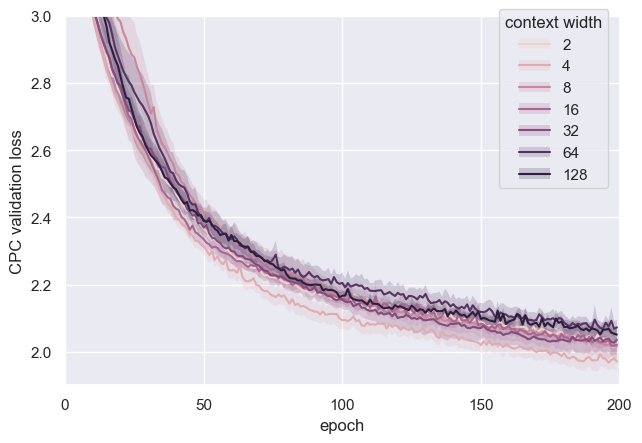

In [11]:
# regular training

df = filter_data_equal(dft, {
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    "training.cpc_loss.gutted_steps": 0,
    'training.cpc_loss.averaging_penalty': 0,
    "training.cpc_loss.prediction_steps": 12,
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "training.max_epochs": 200,
    "train_part": "100",
})
df = filter_data_in(
    df, {"csa.max_width": WIDTHS}
).copy()

check_data(
    df, "tb.epoch", "tb.val_loss", "tb.step", "csa.max_width"
)
# 5 seeds * 7 context windows
assert len(pd.unique(df['name'])) == 5 * 7

fig = plt.figure(1, figsize=[6.8, 4.8])
plot = (
    so.Plot(df, x="tb.epoch", y="tb.val_loss", color="csa.max_width")
    .limit(y=(1.9, 3.0), x=(0, 200))
    .add(so.Line(), so.Agg())
    .add(so.Band(), so.Est(errorbar="se"), group="csa.max_width")
    .label(x="epoch", y="CPC validation loss", color="context width")
    .scale(
        color=so.Continuous(trans="log")
            .tick(at=(2, 4, 8, 16, 32, 64, 128))
            .label(like=".0f"))
    .on(fig)
)

plot.plot()

leg = fig.legends[0]
bb = leg.get_bbox_to_anchor().transformed(fig.axes[0].transAxes.inverted())
bb.x0 -= .335
bb.y0 += .41
leg.set_bbox_to_anchor(bb, transform=fig.axes[0].transAxes)

fig.tight_layout()
fig.savefig('../resources/train_loss_vs_width.pdf')

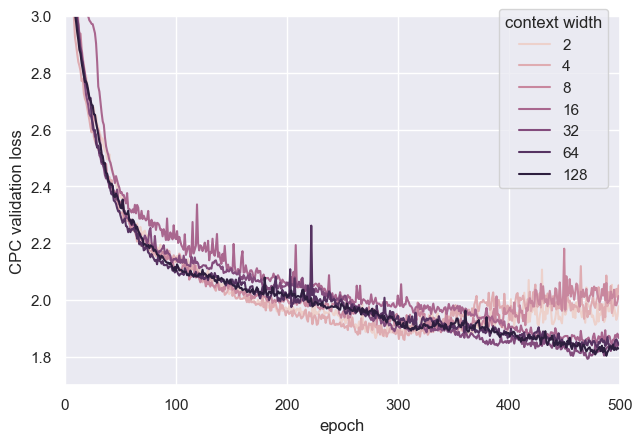

In [12]:
# long training
df = filter_data_equal(dft, {
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    "training.cpc_loss.gutted_steps": 0,
    'training.cpc_loss.averaging_penalty': 0,
    "training.cpc_loss.prediction_steps": 12,
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "training.max_epochs": 500,
})
df = filter_data_in(
    df, {"csa.max_width": WIDTHS}
).copy()

check_data(
    df, "tb.epoch", "tb.val_loss", "tb.step", "csa.max_width"
)
# 7 context windows
assert len(pd.unique(df['name'])) == 7

fig = plt.figure(1, figsize=[6.8, 4.8])
plot = (
    so.Plot(df, x="tb.epoch", y="tb.val_loss", color="csa.max_width")
    .limit(y=(1.7, 3.0), x=(0, 500))
    .add(so.Line(), so.Agg())
    .label(x="epoch", y="CPC validation loss", color="context width")
    .scale(
        color=so.Continuous(trans="log")
            .tick(at=(2, 4, 8, 16, 32, 64, 128))
            .label(like=".0f"))
    .on(fig)
)

plot.plot()

leg = fig.legends[0]
bb = leg.get_bbox_to_anchor().transformed(fig.axes[0].transAxes.inverted())
bb.x0 -= .335
bb.y0 += .41
leg.set_bbox_to_anchor(bb, transform=fig.axes[0].transAxes)

fig.tight_layout()
fig.savefig('../resources/train_loss_vs_width_long.pdf')